# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils import np_utils, plot_model
from matplotlib import pyplot as pl
from skimage import exposure
from skimage.feature import hog
from sklearn import metrics as me

from utils import plot_confusion_matrix

%matplotlib inline

2023-04-30 22:49:33.902227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 22:49:34.315593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [3]:
n_orientations = 4
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [4]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

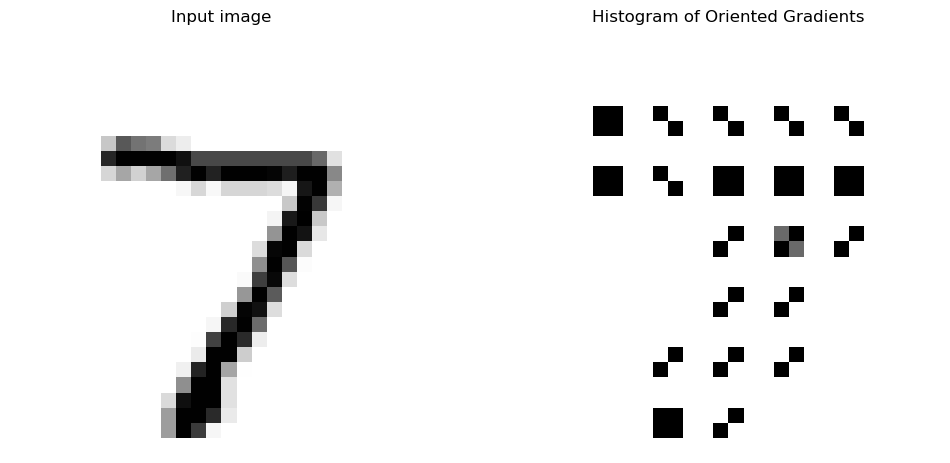

In [5]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets

> Indented block



In [6]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [7]:
model = Sequential([
    Dense(256, input_shape=(hog_size,), activation='relu'),
    Dropout(0.4),
    Dense(n_classes, activation='softmax'),
])

model.summary()

2023-04-30 22:50:13.652257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:50:13.662129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:50:13.662179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:50:13.664298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 22:50:13.664341: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               50432     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 53,002
Trainable params: 53,002
Non-trainable params: 0
_________________________________________________________________


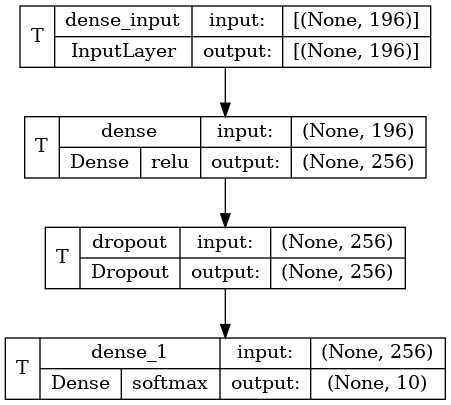

In [8]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    show_trainable=True,
    to_file='mlpf-model.png'
)

Define some constants and train the MLP

In [9]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_split=0.1)

Epoch 1/10
 31/422 [=>............................] - ETA: 1s - loss: 1.3271 - accuracy: 0.6855

2023-04-30 22:50:15.682313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


422/422 [==============================] - 3s 6ms/step - loss: 0.3475 - accuracy: 0.9045 - val_loss: 0.1200 - val_accuracy: 0.9620
Epoch 2/10
422/422 [==============================] - 2s 6ms/step - loss: 0.1566 - accuracy: 0.9499 - val_loss: 0.0995 - val_accuracy: 0.9687
Epoch 3/10
422/422 [==============================] - 10s 24ms/step - loss: 0.1352 - accuracy: 0.9564 - val_loss: 0.0915 - val_accuracy: 0.9715
Epoch 4/10
422/422 [==============================] - 14s 32ms/step - loss: 0.1193 - accuracy: 0.9616 - val_loss: 0.0836 - val_accuracy: 0.9745
Epoch 5/10
422/422 [==============================] - 30s 72ms/step - loss: 0.1080 - accuracy: 0.9654 - val_loss: 0.0823 - val_accuracy: 0.9732
Epoch 6/10
422/422 [==============================] - 55s 131ms/step - loss: 0.1008 - accuracy: 0.9685 - val_loss: 0.0783 - val_accuracy: 0.9757
Epoch 7/10
422/422 [==============================] - 35s 84ms/step - loss: 0.0942 - accuracy: 0.9704 - val_loss: 0.0778 - val_accuracy: 0.9752
Epoch 

Show the performance of the model

Test score: 0.07591433823108673
Test accuracy: 0.9757000207901001


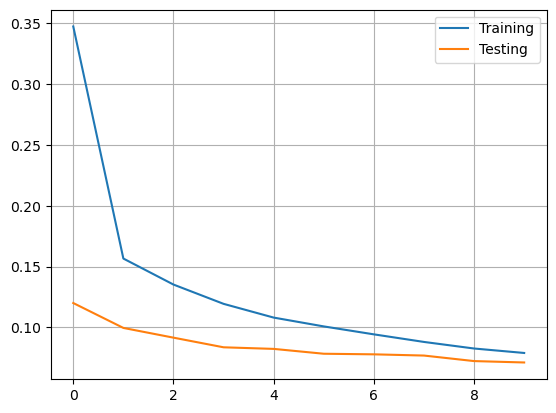

In [10]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

313/313 [==============================] - 0s 1ms/step


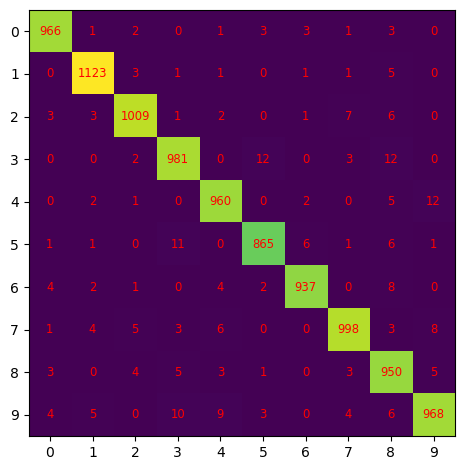

F-score 0: 0.9847094801223242
F-score 1: 0.9868189806678382
F-score 2: 0.9800874210781934
F-score 3: 0.970326409495549
F-score 4: 0.975609756097561
F-score 5: 0.9730033745781778
F-score 6: 0.9821802935010483
F-score 7: 0.975562072336266
F-score 8: 0.9605662285136503
F-score 9: 0.9665501747378932


In [11]:
pred = np.argmax(model.predict(X_test_hog), axis=-1)
cm = me.confusion_matrix(y_test, pred)

plot_confusion_matrix(cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])